In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Bidirectional, Input, Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, Normalizer

Using TensorFlow backend.


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,170,174,237,273,281,299,349,367,423,444
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,223,243,259,277,304,333,361,377,383,400
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,584,716,847,986,1171,1251,1320,1423,1468,1572
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,370,376,390,428,439,466,501,525,545,564
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,7,8,8,8,10,14,16,17,19


In [4]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [5]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [6]:
df_wdi = pd.read_csv('datasets/world_development_index_clean.csv')

In [7]:
df_wdi.head()

,Country Name,"Birth rate (per 1,000)","Death, by communicable diseases and others (%)","Death, by non-communicable diseases (%)","Health expenditure per capita, PPP ($)","Death rate (per 1,000)","Hospital beds (per 1,000)","International tourism, number of arrivals",Life expectancy at birth (years),"Mortality rate, adult, female (per 1,000)","Mortality rate, adult, male (per 1,000)","Nurses and midwives (per 1,000)",People using at least basic sanitation services (%),Population ages 65+ (%),Population density (people per sq.km),Population,Smoking prevalence (ages 15+)
0,Saint Vincent and the Grenadines,14.403,13.4,81.0,409.140058,9.162,2.6,80000.0,72.300000,125.864,179.467,2.5801,87.184345,9.589787,282.589744,110210.0,17.580640
1,Morocco,19.399,14.0,79.6,465.699602,5.072,1.1,12289000.0,76.218000,63.356,73.550,1.0979,88.503644,7.012905,80.728519,36029138.0,23.400000
2,Sao Tome and Principe,31.967,33.9,54.7,196.896879,4.908,2.9,33400.0,69.933000,160.771,217.175,2.2600,42.974944,2.925678,219.820833,211028.0,18.037982
3,Serbia,9.200,2.4,94.6,1322.563548,14.800,5.7,1711000.0,76.087805,75.775,143.428,6.1203,97.567199,18.345793,79.831740,6982084.0,38.900000
4,Eswatini,26.773,53.7,36.7,663.252580,9.843,2.1,782000.0,58.319000,350.238,486.090,2.0000,58.351983,4.014588,66.057616,1136191.0,9.000000


In [8]:
# df = df.join(df_wdi.set_index('Country Name'), on='Country/Region').dropna()

In [9]:
# cols = df.columns[4:]

In [10]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
# df['Population'] = np.array([6.4 *(10**9) for x in range(len(df))])

df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


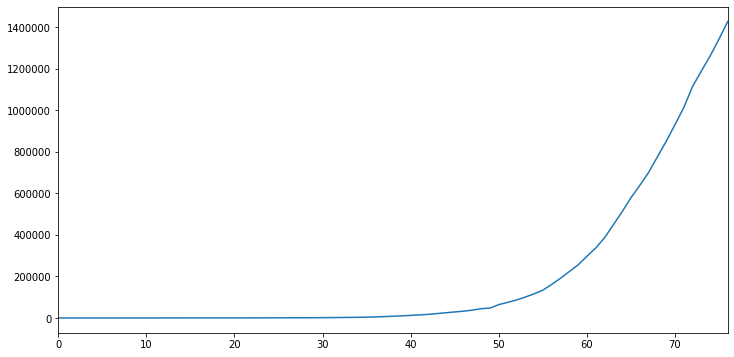

In [11]:
df['Confirmed'].plot(figsize=(12,6))

In [12]:
# df = df.dropna()

In [13]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 18

In [14]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [15]:
training_set = df[:train_index]

In [16]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))

In [17]:
training_set_scaled.shape

(61, 1)

In [18]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
print(X_train.shape, y_train.shape)

(43, 18, 1) (43,)


In [20]:
# X_train[0]

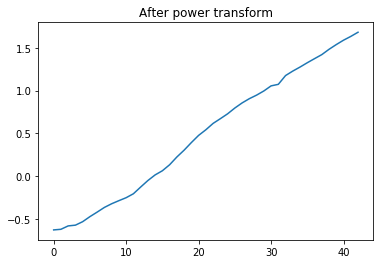

In [21]:
X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [22]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
61,2020-03-24,336454,62
62,2020-03-25,385992,63
63,2020-03-26,447809,64
64,2020-03-27,511394,65
65,2020-03-28,578707,66


In [23]:
real_conf = testing_set['Confirmed'].values

In [24]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [25]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
# inputs
# total
print(X_test.shape)

(16, 18, 1)


In [27]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [28]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [29]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

# population_input_layer = Input(shape=(1,))
# population_dense = Dense(32)(population_input_layer)

# input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm = LSTM(256)(input_layer)
# merge = Concatenate(axis=-1)([lstm,population_dense])
# dropout_lstm = Dropout(0.2)(merge)
# confirmed = Dense(1)(dropout_lstm)

# model = Model([input_layer,population_input_layer], confirmed)
# model.summary()

# model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)


In [30]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
plat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.7)
cb = [checkpoint, plat]

In [31]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
#                     validation_data = (X_test, Y_test),
                    validation_split = 0.1)

Train on 38 samples, validate on 5 samples
Epoch 1/200
38/38 [==============================] - 1s 20ms/step - loss: 0.5640 - val_loss: 0.4786
Epoch 2/200
38/38 [==============================] - 0s 4ms/step - loss: 0.3376 - val_loss: 0.3004
Epoch 3/200
38/38 [==============================] - 0s 4ms/step - loss: 0.2515 - val_loss: 0.2651
Epoch 4/200
38/38 [==============================] - 0s 3ms/step - loss: 0.2201 - val_loss: 0.1576
Epoch 5/200
38/38 [==============================] - 0s 3ms/step - loss: 0.1742 - val_loss: 0.0567
Epoch 6/200
38/38 [==============================] - 0s 4ms/step - loss: 0.1267 - val_loss: 0.0282
Epoch 7/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0865 - val_loss: 0.1033
Epoch 8/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0881 - val_loss: 0.1191
Epoch 9/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0926 - val_loss: 0.1273
Epoch 10/200
38/38 [==============================] - 0s 4ms/step

38/38 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0074

Epoch 00071: ReduceLROnPlateau reducing learning rate to 4.747560842588427e-06.
Epoch 72/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0667 - val_loss: 0.0074
Epoch 73/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0556 - val_loss: 0.0075
Epoch 74/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0429 - val_loss: 0.0075
Epoch 75/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0522 - val_loss: 0.0075

Epoch 00075: ReduceLROnPlateau reducing learning rate to 3.3232926853088427e-06.
Epoch 76/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0727 - val_loss: 0.0075
Epoch 77/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0441 - val_loss: 0.0075
Epoch 78/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0605 - val_loss: 0.0075
Epoch 79/200
38/38 [==============================

38/38 [==============================] - 0s 4ms/step - loss: 0.0501 - val_loss: 0.0078
Epoch 139/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0443 - val_loss: 0.0078

Epoch 00139: ReduceLROnPlateau reducing learning rate to 1.1044275005644976e-08.
Epoch 140/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0598 - val_loss: 0.0078
Epoch 141/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0563 - val_loss: 0.0078
Epoch 142/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0625 - val_loss: 0.0078
Epoch 143/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0389 - val_loss: 0.0078

Epoch 00143: ReduceLROnPlateau reducing learning rate to 7.730992379606505e-09.
Epoch 144/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0488 - val_loss: 0.0078
Epoch 145/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0625 - val_loss: 0.0078
Epoch 146/200
38/38 [======================

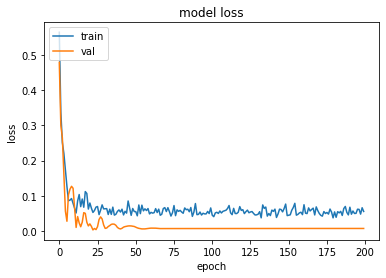

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [33]:
model.load_weights("model.h5")

In [34]:
predicted_conf = model.predict(X_test)

In [35]:
# predicted_conf=pd.DataFrame(predicted_conf)
# X_test[0]

In [36]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
# real_conf

array([[ 352394.66],
       [ 404966.44],
       [ 462900.84],
       [ 527105.6 ],
       [ 598181.44],
       [ 676140.  ],
       [ 759697.5 ],
       [ 846504.1 ],
       [ 936826.6 ],
       [1029728.6 ],
       [1124844.5 ],
       [1222057.1 ],
       [1322410.8 ],
       [1424907.6 ],
       [1527046.1 ],
       [1627543.4 ]], dtype=float32)

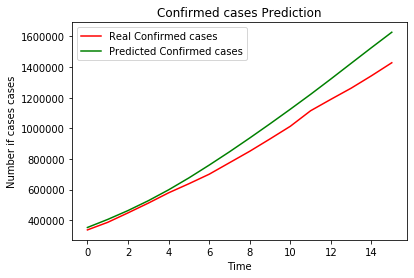

In [37]:
# plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [38]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
# pred_conf
real_conf

array([ 336454,  385992,  447809,  511394,  578707,  638018,  700197,
        775208,  850244,  930888, 1013406, 1114862, 1189513, 1262436,
       1343378, 1428295], dtype=int64)

In [39]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  0.0878796621037455


# For each country

In [35]:
pop = pd.read_csv('datasets\population_data.csv')
pop.head()

,Name,Population,Type
0,Alabama,4888000.0,Province/State
1,Alaska,737438.0,Province/State
2,Alberta,4371000.0,Province/State
3,Anhui,62000000.0,Province/State
4,Arizona,7172000.0,Province/State


In [36]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [37]:
country ='India'

In [38]:
temp = df_c[df_c['Country/Region'] == country]
temp = temp[temp['Confirmed'] > 0].fillna(0).reset_index()
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,index,Country/Region,Lat,Long,Date,Confirmed
0,1366,India,21.0,78.0,2020-01-30,1
1,1550,India,21.0,78.0,2020-01-31,1
2,1734,India,21.0,78.0,2020-02-01,1
3,1918,India,21.0,78.0,2020-02-02,2
4,2102,India,21.0,78.0,2020-02-03,3


In [39]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
65,13326,India,21.0,78.0,2020-04-04,3082,66
66,13510,India,21.0,78.0,2020-04-05,3588,67
67,13694,India,21.0,78.0,2020-04-06,4778,68
68,13878,India,21.0,78.0,2020-04-07,5311,69
69,14062,India,21.0,78.0,2020-04-08,5916,70


In [66]:
wdi_cols = df_wdi.columns

In [67]:
wdi_cols

Index(['Country Name', 'Birth rate (per 1,000)',
       'Death, by communicable diseases and others (%)',
       'Death, by non-communicable diseases (%)',
       'Health expenditure per capita, PPP ($)', 'Death rate (per 1,000)',
       'Hospital beds (per 1,000)',
       'International tourism, number of arrivals',
       'Life expectancy at birth (years)',
       'Mortality rate, adult, female (per 1,000)',
       'Mortality rate, adult, male (per 1,000)',
       'Nurses and midwives (per 1,000)',
       'People using at least basic sanitation services (%)',
       'Population ages 65+ (%)', 'Population density (people per sq.km)',
       'Population', 'Smoking prevalence (ages 15+)'],
      dtype='object')

In [ ]:
# [df_c['Country Name'] == country]

In [40]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 18

In [41]:
training = split
total = temp.shape[0]
train_index = int(total*training)
total

70

In [42]:
training_set = temp[:train_index]

In [43]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))

In [44]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [45]:
print(X_train.shape, y_train.shape)

(38, 18, 1) (38,)


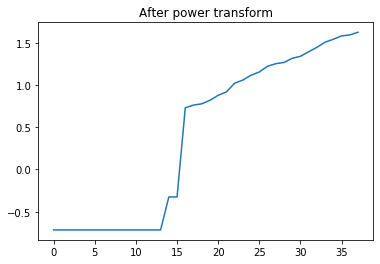

In [46]:
# X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [47]:
testing_set = temp[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
56,11670,India,21.0,78.0,2020-03-26,727,57
57,11854,India,21.0,78.0,2020-03-27,887,58
58,12038,India,21.0,78.0,2020-03-28,987,59
59,12222,India,21.0,78.0,2020-03-29,1024,60
60,12406,India,21.0,78.0,2020-03-30,1251,61


In [48]:
real_conf = testing_set['Confirmed'].values

In [49]:
# test_set=testing_set['Confirmed']
# test_set=pd.DataFrame(test_set)


In [50]:
inputs = temp['Confirmed'][len(temp) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [51]:
# inputs
# total

In [52]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))
# Y_test

In [53]:
print(X_test.shape, Y_test.shape)

(14, 18, 1) (14, 1)


In [54]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [55]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

# population_input_layer = Input(shape=(1,))
# population_dense = Dense(32)(population_input_layer)

# input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm = LSTM(256)(input_layer)
# merge = Concatenate(axis=-1)([lstm,population_dense])
# dropout_lstm = Dropout(0.2)(merge)
# confirmed = Dense(1)(dropout_lstm)

# model = Model([input_layer,population_input_layer], confirmed)
# model.summary()

# model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)


In [56]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
plat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=0, factor=0.7)
cb = [checkpoint, plat]

In [57]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
                    verbose = 0,
                    validation_split = 0.1)

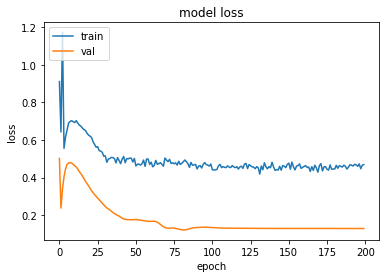

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [59]:
model.load_weights("model.h5")

In [60]:
predicted_conf = model.predict(X_test)

In [61]:
# predicted_conf=pd.DataFrame(predicted_conf)
X_test[0]

array([[0.87830354],
       [0.91883245],
       [1.02178376],
       [1.05895195],
       [1.11583198],
       [1.15432635],
       [1.22233917],
       [1.25242944],
       [1.26720456],
       [1.31559535],
       [1.34008471],
       [1.39367789],
       [1.44554335],
       [1.50738392],
       [1.5414705 ],
       [1.58146232],
       [1.59314585],
       [1.62471916]])

In [62]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
real_conf

array([ 727,  887,  987, 1024, 1251, 1397, 1998, 2543, 2567, 3082, 3588,
       4778, 5311, 5916], dtype=int64)

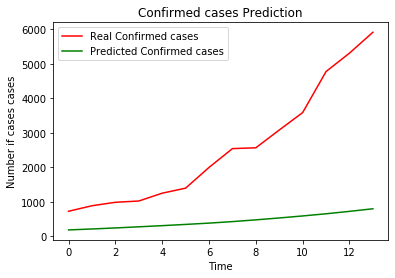

In [63]:
# plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [64]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
pred_conf
real_conf

array([ 727,  887,  987, 1024, 1251, 1397, 1998, 2543, 2567, 3082, 3588,
       4778, 5311, 5916], dtype=int64)

In [65]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  1.655185618468421
